# Phase III: First ML Proof of Concept (5\%)

### Team Names:
-
-
-

Due to the large amount of data in all our cleaned csv files, we had to randomly pick two csv files from two seasons this year, summer and winter, for two random months (January, July) to identify any patterns. This way, the graphing and analyzing will go more smoothly. Below you can see the new code for cleaning only required csv files:

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#load_dotenv() # comment this out if you aren't putting the api key in a .env

# If you don't feel like installing dotenv just replace the api-key stuff with: api_key = "your_api_key_here" and remove before commit pls
api_key = os.getenv('TRANSITLAND_API_KEY')

base_url = "https://transit.land/api/v2/rest/routes"

In [8]:
# cities and coordinates
cities = [
    {"name": "Boston", "bbox": "-71.191155,42.227926,-70.986166,42.400819"},
    {"name": "New York", "bbox": "-74.259090,40.477399,-73.700272,40.917577"},
    {"name": "Chicago", "bbox": "-87.940101,41.643919,-87.523985,42.023131"},
    {"name": "San Francisco", "bbox": "-122.515,37.703,-122.357,37.812"}
]

# empty dict for the transit info
transit_dict = {
    'city': [],
    'route_name': [],
    'route_type': [],  # categorical route type
    'route_id_numeric': [],  # numeric value of the routeID
    'route_sort_order': [] # numeric value of route order
}

for city in cities:
    all_routes = []
    cursor = None
    
    while True:
        params = {
            "bbox": city['bbox'], 
            "limit": 1000,
            "apikey": api_key
        }
        if cursor:
            params['after'] = cursor
        
        response = requests.get(base_url, params=params)
        data = response.json()
        
        routes = data.get('routes', [])
        if not routes:
            break
            
        all_routes.extend(routes)
        
        meta = data.get('meta', {}) # changed to check every page cause the data was pretty biased before
        cursor = meta.get('after')
        if not cursor:
            break
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # organize cols
    for route in all_routes:
        transit_dict['city'].append(city['name'])
        transit_dict['route_name'].append(route.get('route_long_name', route.get('route_short_name', 'Unknown')))
        
        # obtain categorical route type (0=tram, 1=subway, 2=rail, 3=bus, ...) to measure variability
        transit_dict['route_type'].append(route.get('route_type', 3))
        
        # obtain numeric value of the routeID
        route_id = route.get('id', 0)
        transit_dict['route_id_numeric'].append(route_id if isinstance(route_id, int) else hash(str(route_id)) % 10000)
        
        # obtain numeric value of route order, which notes priority of routes to measure efficiency
        transit_dict['route_sort_order'].append(route.get('route_sort_order', 999))

# convert to df
transit_df = pd.DataFrame(transit_dict)
display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order
0,Boston,Alewife Shuttle Route A,3,145185,1.0
1,Boston,Alewife Shuttle Route B,3,145186,2.0
2,Boston,Alewife Shuttle Route C,3,145187,3.0
3,Boston,Alewife Shuttle Route D,3,145188,4.0
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0
6,Boston,Commuter,3,15660215,1.0
7,Boston,BOSTON LOGAN AIRPORT - NEWARK,3,51181250,0.0
8,Boston,NEWARK - BOSTON LOGAN AIRPORT,3,51181251,0.0
9,Boston,BOSTON SOUTH STATION - NEWARK,3,51181262,0.0


In [9]:
# cleaning data
# lists unnamed routes as having an unknown name
transit_df['route_name'] = transit_df['route_name'].replace('', 'Unknown')
transit_df.loc[transit_df['route_name'].isna(), 'route_name'] = 'Unknown'\

# sets the route sor torder to a float and replaces any missing sort orders with 999
transit_df['route_sort_order'] = transit_df['route_sort_order'].fillna(999)
transit_df['route_sort_order'] = transit_df['route_sort_order'].astype(float)

# removes duplicate routes
transit_df = transit_df.drop_duplicates(subset=['city', 'route_id_numeric'], keep='first')

# makes all route types ints and replaces missing route types with 3
transit_df['route_type'] = transit_df['route_type'].fillna(3)
transit_df['route_type'] = transit_df['route_type'].astype(int)

# summarizes some the city statistics
city_summary = transit_df.groupby('city').agg({
    'route_id_numeric': 'count', # total number of routes in each city
    'route_type': 'nunique', # number of different types of transit
    'route_sort_order': 'mean' # average route priority, lower = more priority
}).reset_index()

# renames columns for the city summary
city_summary.columns = [
    'city',
    'total_routes',
    'route_type_diversity',
    'avg_route_priority'
]

# transit richness score
# 50% weight in number of cities
# 30% weight in the number of transit types
# 20% weight in the average priority
city_summary['transit_richness_score'] = (
    (city_summary['total_routes'] / city_summary['total_routes'].max() * 50) +
    (city_summary['route_type_diversity'] / city_summary['route_type_diversity'].max() * 30) +
    ((1 / (city_summary['avg_route_priority'] + 1)) / 
     (1 / (city_summary['avg_route_priority'] + 1)).max() * 20)
)

# classify cities by transit richness score
# above median = transit rich
# below median = transit limited
median_score = city_summary['transit_richness_score'].median()
city_summary['transit_category'] = city_summary['transit_richness_score'].apply(
    lambda x: 'Transit-Rich' if x >= median_score else 'Transit-Limited'
)

display(city_summary)

# merges the route data with the city summary
city_cols = ['city', 'total_routes', 'route_type_diversity', 'transit_richness_score', 'transit_category']
transit_df_merged = transit_df.merge(city_summary[city_cols], on='city', how='left')

transit_df_merged.to_csv('transit_df.csv', index=False)

display(transit_df_merged.head(30))

,city,total_routes,route_type_diversity,avg_route_priority,transit_richness_score,transit_category
0,Boston,390,5,39314.679487,44.205820,Transit-Limited
1,Chicago,264,4,984.314394,50.172407,Transit-Limited
2,New York,1039,6,859.567854,100.000000,Transit-Rich
3,San Francisco,161,6,999.000000,54.959192,Transit-Rich


,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category
0,Boston,Alewife Shuttle Route A,3,145185,1.0,390,5,44.20582,Transit-Limited
1,Boston,Alewife Shuttle Route B,3,145186,2.0,390,5,44.20582,Transit-Limited
2,Boston,Alewife Shuttle Route C,3,145187,3.0,390,5,44.20582,Transit-Limited
3,Boston,Alewife Shuttle Route D,3,145188,4.0,390,5,44.20582,Transit-Limited
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0,390,5,44.20582,Transit-Limited
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0,390,5,44.20582,Transit-Limited
6,Boston,Commuter,3,15660215,1.0,390,5,44.20582,Transit-Limited
7,Boston,BOSTON LOGAN AIRPORT - NEWARK,3,51181250,0.0,390,5,44.20582,Transit-Limited
8,Boston,NEWARK - BOSTON LOGAN AIRPORT,3,51181251,0.0,390,5,44.20582,Transit-Limited
9,Boston,BOSTON SOUTH STATION - NEWARK,3,51181262,0.0,390,5,44.20582,Transit-Limited


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np

### Attempt 1 - Linear Regression

In [22]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.
    
    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph
    
    Returns:
        An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse.round(3)}")
    r2 = 1 - (mse/y.var())
    print(f"{title} - R2: {r2.round(4)}")
    
    # Residuals
    residuals = y_test - y_pred
    
    # Diagnostic Plots
    plt.figure(figsize=(16, 12))
    
    # 1. Residuals vs Fitted (Linearity/Constant Variance)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residual plot vs Order")
        
    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')

    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Model 1: Time of Day
Time of Day Model - Mean Squared Error: 514.094
Time of Day Model - R2: 0.0477


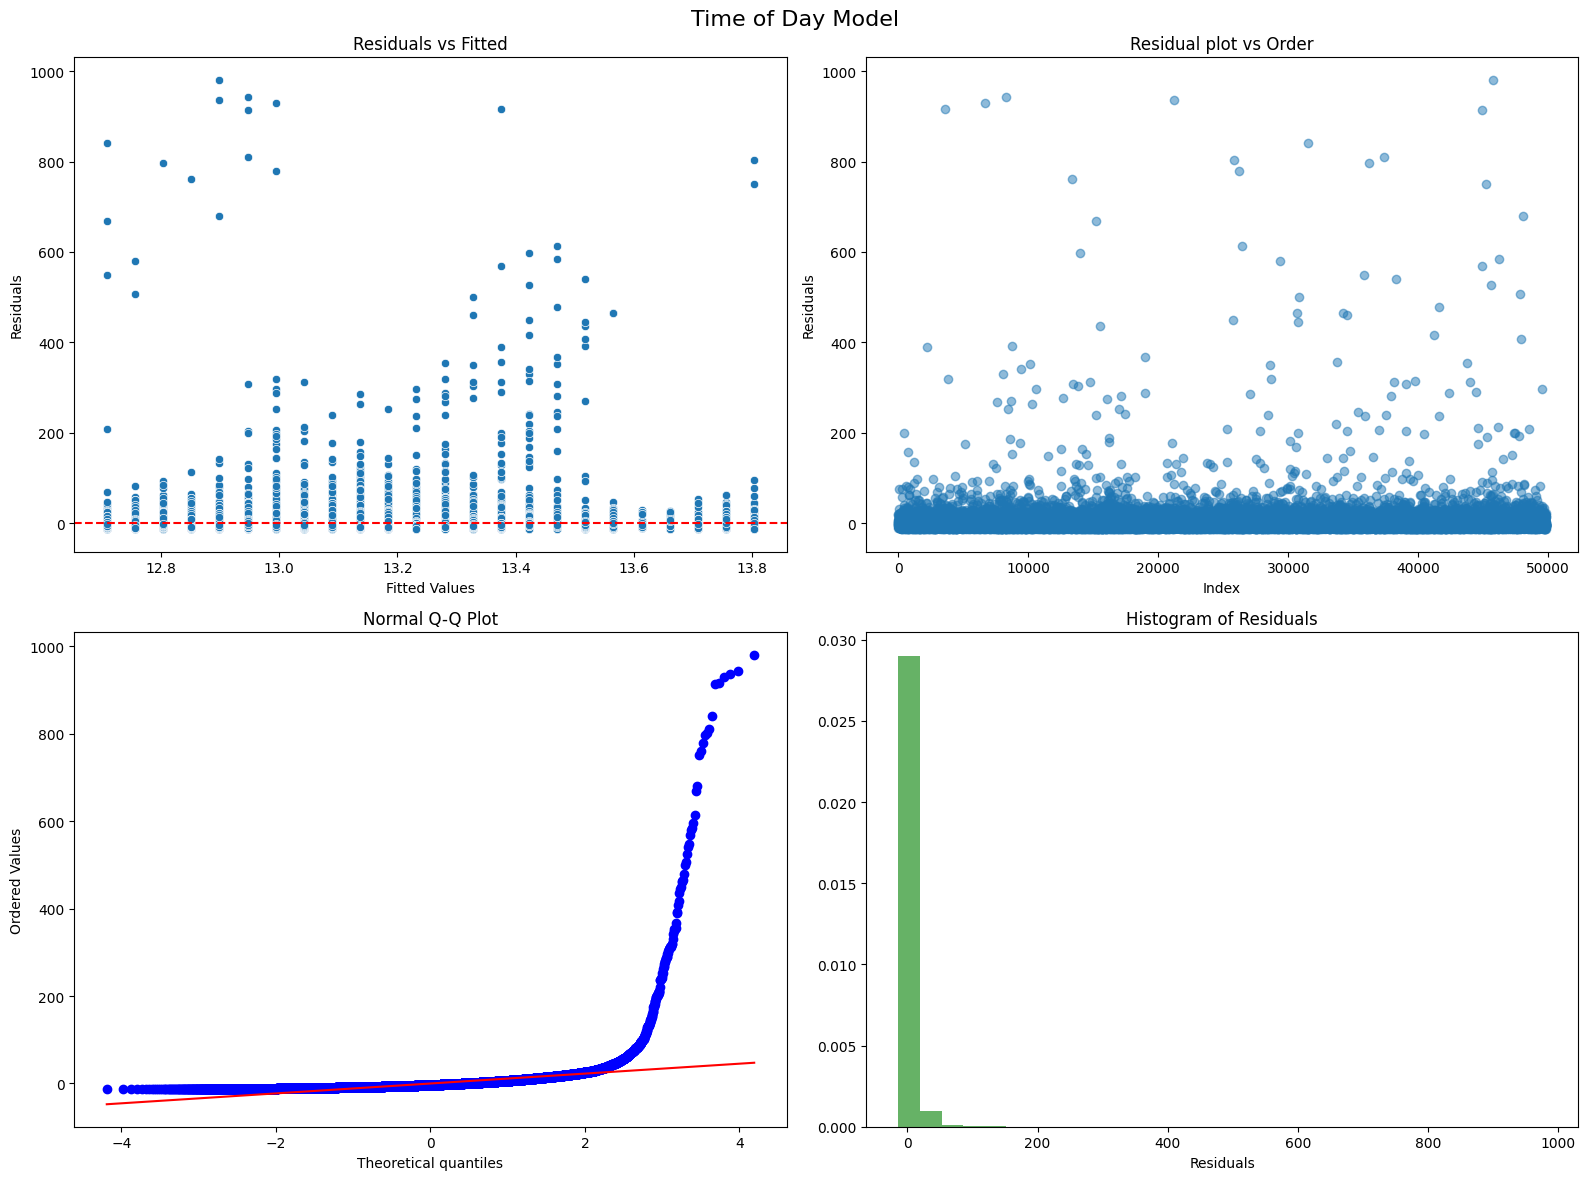

Model 2: User Demographics
User Demographics Model - Mean Squared Error: 508.001
User Demographics Model - R2: 0.059


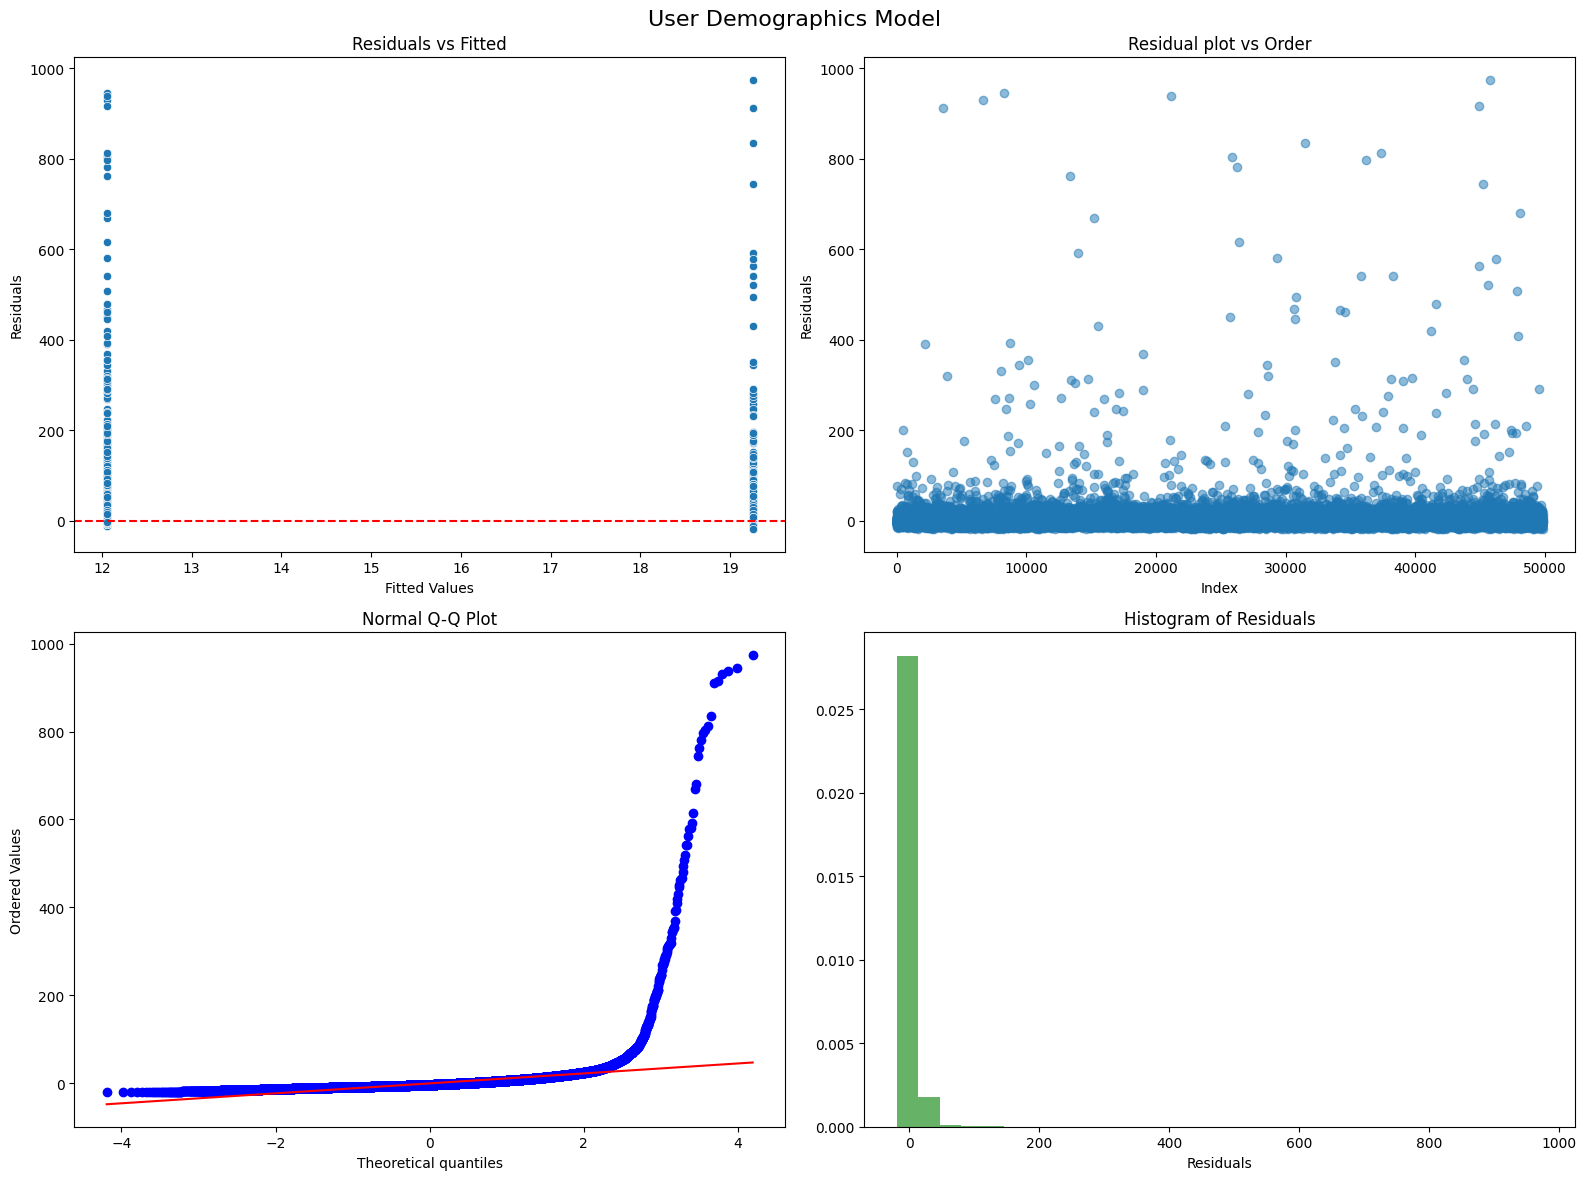

Model 3: Starting and Ending Stations
Starting and Ending Stations Model - Mean Squared Error: 514.076
Starting and Ending Stations Model - R2: 0.0478


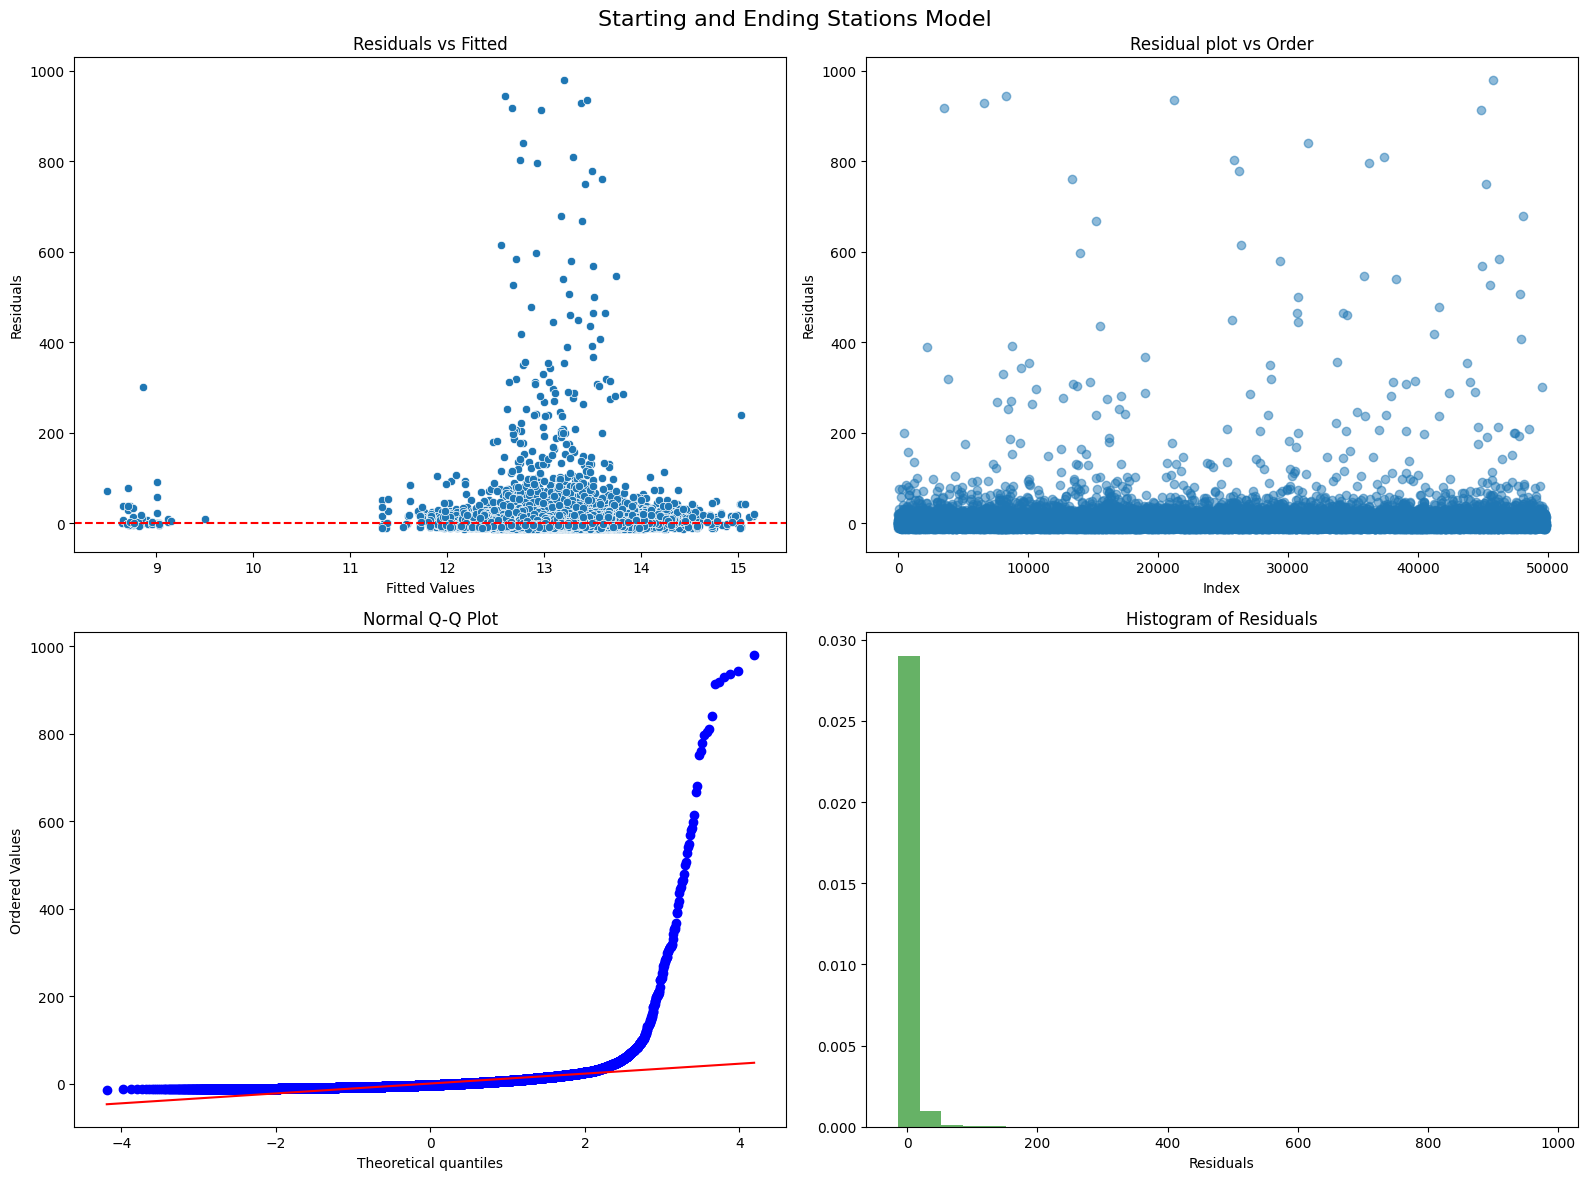

In [23]:
# Main function to answer the question
def main(): 
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """
    try:
        df = pd.read_csv(jan_csv_path)
        df = preprocess_data(df)
        
        # Model 1: Time of Day
        print("Model 1: Time of Day")
        X_time = df[['hour']]
        y_time = df['tripduration']
        evaluate_model(X_time, y_time, "Time of Day Model")
        
        # Model 2: User Demographics
        print("Model 2: User Demographics")
        df['member_casual'] = df['member_casual'].astype('category').cat.codes
        X_demo = df[['member_casual']]
        y_demo = df['tripduration']
        evaluate_model(X_demo, y_demo, "User Demographics Model")
        
        # Model 3: Starting and Ending Stations
        print("Model 3: Starting and Ending Stations")
        X_station = df[['start_lat', 'start_lng', 'end_lat', 'end_lng']]
        y_station = df['tripduration']
        evaluate_model(X_station, y_station, "Starting and Ending Stations Model")
    
    except FileNotFoundError:
        print(f"File not found: {jan_csv_path}")
    except ValueError as e:
        print(str(e))

# Run the main function
if __name__ == '__main__':
    main()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [11]:
df = pd.read_csv('transit_df.csv')
df.head()

,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category
0,Boston,Alewife Shuttle Route A,3,145185,1.0,390,5,44.20582,Transit-Limited
1,Boston,Alewife Shuttle Route B,3,145186,2.0,390,5,44.20582,Transit-Limited
2,Boston,Alewife Shuttle Route C,3,145187,3.0,390,5,44.20582,Transit-Limited
3,Boston,Alewife Shuttle Route D,3,145188,4.0,390,5,44.20582,Transit-Limited
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0,390,5,44.20582,Transit-Limited


In [19]:
from sklearn.preprocessing import PolynomialFeatures

# prepare the data
X_route_type = np.array(df['route_type']).reshape(-1, 1)
y = np.log1p(df['route_sort_order'])

In [21]:
# degree 2 for polynomial regression (might change this later ngl)
poly = PolynomialFeatures(degree=2)
# gets the X_poly with bias column in the beginning
X_poly_bias = poly.fit_transform(X_route_type)
# removes the bias column
X_poly = X_poly_bias[:, 1:]
print("First polynomial feature vector:", X_poly[0])

First polynomial feature vector: [3. 9.]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function. 

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [22]:
def add_bias_column(X):
    """ adds a bias column
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [23]:
def line_of_best_fit(X, y):
    """ returns a vector containing the coefficients for the line of best fit, including an intercept term
    Args:
        X (array): either 1-d or 2-d which includes all the predictor values, not including bias term
        y (array): a 1-d array which includes all corresponding response values to X
        
    Returns:
        m (array): the vector containing the coefficients for the line of best fit, including an intercept term
    """
    # adds a bias column to X
    X_new = add_bias_column(X)
    # calculates the line of best fit
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

In [24]:
from sklearn.metrics import r2_score

In [25]:
def linreg_predict(Xnew, ynew, m):
    """ returns a dictionary containing: the predicted values from applying m to Xnew, the residuals, 
    the mean squared error, and the coefficient of determination

    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (array): a 1-d array of length which contains the coefficients from the line_of_best_fit function

    Returns:
        output_dict (dictionary): a dictionary that has:
            - 'ypreds' (the predicted values from applying m to Xnew)
            - 'resids' (the residuals, the differences between ynew and ypreds)
            - 'mse' (the mean squared error)
            - 'r2' (the coefficient of determination representing the proportion of variability in ynew explained by the line of best fit
    """
    # initializes an output dictionary for required values
    output_dict = {}
    # adds a bias column to the Xnew array
    Xnew_bias_added = add_bias_column(Xnew)
    # calculates the line of best fit for Xnew with bias and ynew
    # gets the predicted values from applying m to Xnew
    ypreds = np.matmul(Xnew_bias_added, m)
    # gets the residuals
    res = ynew - ypreds
    # gets the mean squared error
    mse = (res**2).mean()
    # gets the R^2
    r2 = r2_score(ynew, ypreds)
    # adds values to the dictionary
    output_dict['ypreds'] = ypreds
    output_dict['resids'] = res
    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

In [26]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the polynomial regression model =', model['mse'].round(3))
print('R^2 for the polynomial regression model =', round(model['r2'], 4))

MSE for the polynomial regression model = 5.352
R^2 for the polynomial regression model = -0.0259


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [18]:
# Prepares the data
X_hour = np.array(df['hour']).reshape(-1,1)
y = df['tripduration']
X_ride_type = df['member_casual'].astype('category').cat.codes.values.reshape(-1, 1)
X_member_type = df['rideable_type'].astype('category').cat.codes.values.reshape(-1, 1)

# degree 4 for the quadratic equation
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_hour_poly_bias = poly.fit_transform(X_hour)
# removes the bias column
X_hour_poly = X_poly_bias[:, 1:]

# Combines X_hour_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_hour_poly,
    X_ride_type * X_member_type,
    X_ride_type * (1 - X_member_type), 
    (1 - X_ride_type) * X_member_type], axis=1)

print(X_poly[0])

[ 2.  4.  8. 16.  0.  1.  0.]


In [19]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', model['mse'].round(3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 599.699
R^2 for the second poly regression model = 0.0482


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach
The initial question we proposed for Machine Learning part is "Can we predict the trip duration based on factors such as the time of day, user demographics, and starting/ending stations?", and after further discussions and analysis, we identified we can try building the models based on a Linear Regression for 3 features separately and a Polynomial Regression for one of the features. However, as we moved forward in with the Linear Regression analysis, we got unexpectedly large values for both $MSE$ and $R^2$ for all 3 features. This made us reconsider our initial attempt and go with Polynomial Regression for one of the features (Time of Day). After constructing the model equation and using cross-validation, we received values of $MSE$ = 627.869 and $R^2$ = 0.0035, which showed worse results, compared to Linear Regression. Therefore, we decided to fix our model by incorporating interactions with dummy variables (member_casual and rideable_type), which had values of 1 and 0. Building the polynomial regression model with interactions and dummy variables has slighly improved the $MSE$ = 599.699 and $R^2$ = 0.0482. However, the values were still significantly worse, than the Linear Regression model's ones. Therefore, we we will use the Linear Regression model to discuss the preliminary results.

## Model 1
First, we analyzed Model 1: Time of Day of Linear Regression model. We calculated $MSE$ = 514.094 and $R^2$ = 0.0477, where MSE value is lower than for the polynomial regression models and $R^2$ value is slightly lower than the second polynomial regression model. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is violated as the residuals do not follow a linear trend about 0 and also contain multiple outliers. The second plot of Residuals vs Order shows that there is some density of the data points near the y = 0 with mutliple outliers as well, indicating there might be a violation of Independence assumption as well. Looking at the Histogram of Residuals and Q-q plot, we can witness there is strong right-skewedness, showing that there is no normal distribution, meaning violation of Normality assumption. 

## Model 2
Second, we analyzed Model 2: User Demographics of Linear Regression Model. Calculating $MSE$ = 508.001 and $R^2$ = 0.059 shows that this is the highest values we were able to identify. There is a violation of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not equally distributed around y=0 line, they have significant gaps between vertical line patterns of the data points. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. Therefore, the plots also violate the assumptions, despite better looking values.

## Model 3
Finally, the last Model 3: Starting and Ending Stations has $MSE$ = 514.076 and $R^2$ = 0.0478, the values are somewhat similar to the ones from Model 1. The model also fails to meet the assumptions of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not distributed closer to y=0 line, have occasional gaps and outliers. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. 

## Conclusions
These findings paint a complex picture of the bike-sharing prediction challenge. While Linear Regression provided our best results among the attempted approaches, the consistent violations of key assumptions across all models reveal fundamental challenges in our modeling strategy. 

First, the pervasive violations of regression assumptions across all models suggest systemic issues in how we're approaching the prediction task. The violation of linearity assumptions, evidenced by clear patterns in our residual plots, indicates that the relationship between our predictors and trip duration isn't as straightforward as our models assume. For instance, the impact of time of day on trip duration might follow a more complex pattern influenced by rush hours, weekends, or seasonal effects that our linear approach can't capture. Similarly, the relationship between station locations and trip duration might be influenced by geographic features, traffic patterns, or neighborhood characteristics that require more sophisticated modeling approaches.

The heteroscedasticity observed in our models (non-constant variance in residuals) suggests that our predictions' accuracy varies significantly across different conditions. This could indicate that trip durations are more predictable in some circumstances than others – perhaps more consistent during regular commuting hours but more variable during leisure times. This varying predictability challenges our model's ability to provide reliable estimates across all scenarios.

The notably low R² values (ranging from 0.0477 to 0.059) are particularly telling. These values indicate that our models explain less than 6% of the variance in trip durations, leaving over 94% of the variation unexplained. This substantial unexplained variance could stem from several sources, such as missing key features, complex interaction, or hidden variables.

Future research directions might include:
- Exploring more sophisticated modeling techniques such as mixed-effects models to account for hierarchical structure in the data
- Investigating even more additional features that might better explain trip duration variability
- Considering non-parametric approaches that don't rely on the strict assumptions of linear regression
- Implementing geospatial modeling techniques to better capture the impact of station locations

 Understanding these limitations and potential improvements is crucial for developing more effective prediction models in future iterations. The complexity revealed by our analysis suggests that successful trip duration prediction might require a more nuanced, multi-model approach that can adapt to different conditions and user patterns. Our results demonstrate the challenges of real-world predictive modeling and the importance of thorough diagnostic testing, even when working with seemingly straightforward prediction tasks.